<a href="https://colab.research.google.com/github/JamesRonsonOp/varietal_predictor/blob/main/03_modeling_notebooks/001_neural_net_21_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_______
# About This Notebook
_______

This notebook takes in data housed on github that was preprocessed in a previous notebook dedicated to preprocessing and EDA. 

### This Notebook Performs the following Functions: 

* 1. Creates a CNN Neural Net
* 2. Plots a CNN Neural Net

____
### Content Links
____

* [Baseline](#base)
* [Data Preparation](#prep)
* [Sparseness Analysis](#sparse)
* [Neural Net Creation](#instance)
* [Compiling Neural Net](#compile)
* [Layer Summary](#summary)
* [Fitting Neural Net](#fit)
* [Results Plot](#plot)



_______
### Imports
______


In [ ]:
# Standard Imports
import pandas as pd
import numpy as np

# Importing Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


# Tensorflow/Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer


_______
### Read in Data
_______

In [ ]:
# Reading data from github raw csv
wine_df = pd.read_csv('https://raw.githubusercontent.com/JamesRonsonOp/capstone/main/data/003_preprocessed_all_data%20copy.csv')

In [ ]:
wine_df.head()

,varietal,description,color,parsed,parsed_w_stops
0,Riesling,pineapple rind lemon pith blossom start bit op...,white,pineapple rind lemon pith and orange blossom s...,pineapple rind lemon pith blossom start bit op...
1,Gewurztraminer,restrained profusion balanced acidity firm tex...,white,this dry and restrained wine offers spice in p...,restrained profusion balanced acidity firm tex...
2,Gewurztraminer,savory dried thyme accent sunnier preserved br...,white,savory dried thyme notes accent sunnier flavor...,savory dried thyme accent sunnier preserved br...
3,Gewurztraminer,tight taut texture strongly layered aftertaste,white,this is a dry wine very spicy with a tight tau...,tight taut texture strongly layered aftertaste
4,Chardonnay,building trends leaner buttercream aroma every...,white,building on years and six generations of winem...,building trends leaner buttercream aroma every...


In [ ]:
wine_df['varietal'].value_counts()

Cabernet Sauvignon    15199
Pinot Noir            12193
Chardonnay            10779
Riesling               4759
Syrah                  4606
Sauvignon Blanc        4545
Merlot                 2887
Nebbiolo               2594
Zinfandel              2524
Sangiovese             2456
Malbec                 2446
Tempranillo            2219
Gruner Veltliner       1196
Pinot Grigio            978
Gewurztraminer          937
Viognier                919
Grenache                605
Glera                   596
Chenin Blanc            543
Albarino                434
Garganega               244
Name: varietal, dtype: int64

_____
**Remove Nulls**
Somehow nulls leaked into my data despite the fact that prior to exporting from last notebook they had no nulls. Not sure how this happened but I am removing the nulls here. 
____

In [ ]:
wine_df.isna().sum()

varietal          0
description       6
color             0
parsed            0
parsed_w_stops    6
dtype: int64

In [ ]:
wine_df.dropna(inplace = True)
wine_df.isna().sum()

varietal          0
description       0
color             0
parsed            0
parsed_w_stops    0
dtype: int64

In [ ]:
wine_df['parsed'] = wine_df['parsed'] + ' ' + wine_df['color']

<a id='base'></a>
<a name="base"></a>
____
### Baseline Model For Multi-Class Classification
____

Guessing at random would give us the following probabilities of predicting each class

In [ ]:
wine_df['varietal'].value_counts(normalize = True)

Cabernet Sauvignon    0.206332
Pinot Noir            0.165533
Chardonnay            0.146348
Riesling              0.064614
Syrah                 0.062536
Sauvignon Blanc       0.061708
Merlot                0.039197
Nebbiolo              0.035219
Zinfandel             0.034255
Sangiovese            0.033332
Malbec                0.033210
Tempranillo           0.030128
Gruner Veltliner      0.016238
Pinot Grigio          0.013278
Gewurztraminer        0.012722
Viognier              0.012477
Grenache              0.008201
Glera                 0.008092
Chenin Blanc          0.007372
Albarino              0.005892
Garganega             0.003313
Name: varietal, dtype: float64

<a id='prep'></a>
<a name="prep"></a>
____
# Data Preparation
____


_____
### Tokenizing The Target Column
____

This tokenizer was also a good parameter to adjust to make the neural net function. tens of thousands of features were reduce to just a couple of thousand. 

In [ ]:
# instantiate keras tokenizer
token = Tokenizer(num_words = 2000, oov_token = '<OOV>')
# fit keras tokenizer of predictors column
token.fit_on_texts(wine_df['parsed'])


____
### Creating Vectors that match in shape
_____



In [ ]:
max_len = 0
input_sequences = []
for d in wine_df['parsed']:
    # takes in a list of texts (from 'token') and returns a list of strings
    token_list = token.texts_to_sequences([d])[0]
    # appending tokens to input_sequences
    input_sequences.append(token_list)
    # creating a variable that identifies the length of each description 'd'
    num = len(d)
    # if the number above is > than max_len value rename max_len to that number
    if num > max_len:
        max_len = num

# print max_len just to see what max_num is. 
print(max_len)

739


In [ ]:
# padding the length of all descriptions
# by adding zeros to the length. 
input_sequences = sequence.pad_sequences(input_sequences,maxlen=max_len)



______
### Creating and Encoding Targets
_____

In [ ]:
# Creating target
y = wine_df['varietal']

In [ ]:
# label encoding target
le = LabelEncoder()
y = le.fit_transform(y)

____
### Train/Test Split
_____

With shuffling to ensure randomness in split. 

In [ ]:
 # creating X and y and also...
 # shuffling target and predictors to ensure randomness in the train/test splits
 X = tf.random.shuffle(input_sequences, seed=42)
 y = tf.random.shuffle(y, seed=42)


In [ ]:
# creating train/split ratio
train_index = int(len(input_sequences) * .7)

# creating training and validation datasets for targets and predictors
X_train = X[0:train_index]
X_test = X[train_index: ]
y_train = y[0:train_index]
y_test = y[train_index:]

<a id='sparse'></a>
<a name="sparse"></a>
____
### Analyzing the Sparseness in the Data
_____

In [ ]:
unique_values = np.unique(X_train, return_counts = True)[1].sum()
print(f'There are {unique_values} in training data set.')
zeros = np.unique(X_train, return_counts = True)[1][0]
print(f'There are {zeros} zeros in the training data set.')
pct_zero = round(zeros / unique_values * 100,2)
print(f'Zeros account for {pct_zero}% of the training data set.')

There are 38100623 in training data set.
There are 35918117 zeros in the training data set.
Zeros account for 94.27% of the training data set.


<a id='instance'></a>
<a name="instance"></a>
____
# Neural Net Creation
____

Instantiating the model and creating the layers for my nueral net. 




In [ ]:
# setup early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


# Instantiating Neural Net
model = tf.keras.models.Sequential([
    # input = 1000 words, next layer inputis 32, input length is the max length
        tf.keras.layers.Embedding(2000, 32, input_length=max_len),
        tf.keras.layers.Conv1D(64, 3, padding = 'same', activation = 'relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(.7),
        tf.keras.layers.Dense(21, activation = 'softmax',)
])



<a id='compile'></a>
<a name="compile"></a>
___
### Compiling Neural Net
____

* There were few loss functions that worked with my data. I settled on Sparse Categorical Crossentropy after reviewing my options on SKlearn and iterating through a few others to see if they worked. 

* I am limited to 'accuracy' metric at this point because I was unable to successfully binarize my target columns and get them to shape correctly to fit the neural net. I will eventually go back and attempt to do this again as binarization of targets allows for more classification metrics. 

In [ ]:
# Compiling Neural Net
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])



<a id='summary'></a>
<a name="summary"></a>

______
### Layer Summary
______

I used a 1 dimensional Convolution layer first because I read somewhere that it works well with NLP. It takes into account the proximity of words to create trainable patterns. I then added a max pooling layer. Apparently layering it after a convolutional layer is a common pattern. It works along the lines of calculating the maximum value for each piece of data or patch of the feature map. It basically give a summarized version of the features to the next layer of the neural net. This extracts the most meaningful features. I then use a flattening layer to convert it to a 1D array for input into the next layer. After that I used a dense layer. Apparently it is most common layer used and I guess you could just call it a regular layer in a neural network. I then finish it off with a dropout layer and another dense layer. The dropout layer combats overfitting. It is a regularization technique that gives it a ratio between 0 and 1. It essentially deactivates that ratio of neurons in the net.

In [ ]:
# Showing Neural Net Structure
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 739, 32)           64000     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 739, 64)           6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 369, 64)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 23616)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               3022976   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 21)               

<a id='fit'></a>
<a name="fit"></a>
_______
# Fitting the Neural Net
_______

In [ ]:
# Fitting nuerual net and showing results
history = model.fit(X_train, y_train, epochs = 10, 
                    batch_size = 32, validation_data = (X_test, y_test),
                    callbacks = [callback])


Epoch 1/10
1612/1612 [==============================] - 43s 26ms/step - loss: 2.0158 - accuracy: 0.3754 - val_loss: 1.1991 - val_accuracy: 0.5766
Epoch 2/10
1612/1612 [==============================] - 42s 26ms/step - loss: 1.3141 - accuracy: 0.5573 - val_loss: 1.0676 - val_accuracy: 0.6368
Epoch 3/10
1612/1612 [==============================] - 42s 26ms/step - loss: 1.1854 - accuracy: 0.5987 - val_loss: 1.0043 - val_accuracy: 0.6556
Epoch 4/10
1612/1612 [==============================] - 45s 28ms/step - loss: 1.1099 - accuracy: 0.6246 - val_loss: 0.9623 - val_accuracy: 0.6729
Epoch 5/10
1612/1612 [==============================] - 42s 26ms/step - loss: 1.0427 - accuracy: 0.6442 - val_loss: 0.9415 - val_accuracy: 0.6911
Epoch 6/10
1612/1612 [==============================] - 44s 27ms/step - loss: 0.9720 - accuracy: 0.6671 - val_loss: 0.9147 - val_accuracy: 0.7037
Epoch 7/10
1612/1612 [==============================] - 43s 26ms/step - loss: 0.9412 - accuracy: 0.6761 - val_loss: 0.8976 -

<a id='plot'></a>
<a name="plot"></a>
____
# Plotting the Neural Net Results
______

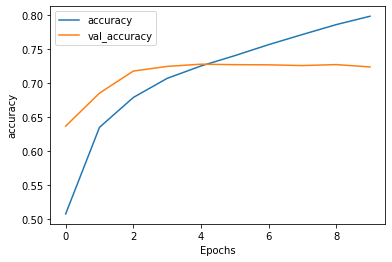

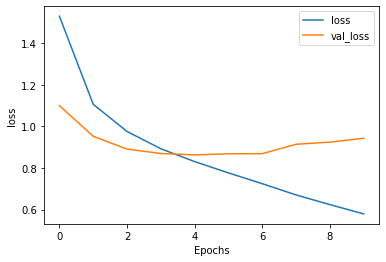

In [ ]:
# Plotting Neural Net results
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

___
**Interpreting Plot Results**
____

At around 3 Epochs we find convergence of both the loss function and the accuracy score. It is there where we could reasonably assume that the score would be most true. At point of convergence accuracy was around 73% for both training and validating scores and the loss function was around .9 for both training and validating sets. 

_____
**Next Steps**
______
Play around more with adding and dropping layers, gather more data and introduce it to see how well it performs, binarize targets and successfuly fit binarized targets to model. 